# **Computational Linguistics 23/24 Final Project** <br>
Name: Ho-Hsuan Wang <br>
Student Number: 7038925 <br>
Date: 22nd March <br>

## 1. Download and Inspect Datasets

In [ ]:
pip install requests conllu


In [ ]:
import requests
from conllu import parse
from io import StringIO

Link to UD_Chinese-GSD repository: https://github.com/UniversalDependencies/UD_Chinese-GSD

Description: UD_Chinese-GSD is a traditional Chinese Universal Dependencies Treebank annotated and converted by Google.

In [ ]:

links_to_datasets = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-GSD/master/zh_gsd-ud-train.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-GSD/master/zh_gsd-ud-test.conllu",
}

def download_and_parse(url):
    response = requests.get(url)
    response.raise_for_status()
    file_content = response.text
    parsed_data = parse(file_content)
    return parsed_data

# Column headers and descriptions
columns_info = {
    "ID": "Token ID, integer or decimal for multiword tokens",
    "FORM": "Form or spelling of the word",
    "LEMMA": "Lemma or base form of the word",
    "UPOS": "Universal Part-of-Speech tag",
    "XPOS": "Language-specific part-of-speech tag",
    "FEATS": "Morphological features",
    "HEAD": "Head of the current token in a dependency parse",
    "DEPREL": "Dependency relation to the HEAD",
    "DEPS": "Enhanced dependency graph",
    "MISC": "Any other annotation"
}

datasets = {name: download_and_parse(url) for name, url in links_to_datasets.items()}

# Print column information
print("CoNLL-U Format Columns:")
for column, description in columns_info.items():
    print(f"{column}: {description}")
print("\n---\n")

# Print dataset information
for name, data in datasets.items():
    print(f"Dataset: {name}, Sentences: {len(data)}")
    if data:
        first_sentence = data[0]
        print(f"# sent_id = {first_sentence.metadata['sent_id']}")
        print(f"# text = {first_sentence.metadata['text']}")
        if 'translit' in first_sentence.metadata:
            print(f"# translit = {first_sentence.metadata['translit']}")
        for token in first_sentence:
            print(f"{token['id']}\t{token['form']}\t{token['lemma']}\t{token['upos']}\t{token['xpos']}\t{'_'}\t{token.get('head', '_')}\t{token['deprel']}\t{'_'}\t{'|'.join([f'{k}={v}' for k, v in token['misc'].items()]) if token['misc'] else '_'}")
    print("\n---\n")


CoNLL-U Format Columns:
ID: Token ID, integer or decimal for multiword tokens
FORM: Form or spelling of the word
LEMMA: Lemma or base form of the word
UPOS: Universal Part-of-Speech tag
XPOS: Language-specific part-of-speech tag
FEATS: Morphological features
HEAD: Head of the current token in a dependency parse
DEPREL: Dependency relation to the HEAD
DEPS: Enhanced dependency graph
MISC: Any other annotation

---

Dataset: train, Sentences: 3997
# sent_id = train-s1
# text = 看似簡單，只是二選一做決擇，但其實他們代表的是你周遭的親朋好友，試著給你不同的意見，但追根究底，最後決定的還是自己。
# translit = kànshìjiǎndān,zhǐshì'èrxuǎnyīzuòjuézé,dànqíshítāmendàibiǎodeshìnǐzhōuzāodeqīnpénghǎoyou,shìzhegěinǐbùtóngdeyìjiàn,dànzhuīgēnjiūdǐ,zuìhòujuédìngdeháishìzìjǐ.
1	看似	看似	VERB	VV	_	5	advcl	_	SpaceAfter=No|Translit=kànshì|LTranslit=kànshì
2	簡單	簡單	ADJ	JJ	_	1	xcomp	_	SpaceAfter=No|Translit=jiǎndān|LTranslit=jiǎndān
3	，	，	PUNCT	,	_	1	punct	_	SpaceAfter=No|Translit=,|LTranslit=,
4	只	只	ADV	RB	_	5	advmod	_	SpaceAfter=No|Translit=zhǐ|LTranslit=zhǐ
5	是	是	VERB

## 2. Data Preprocessing

Preprocess the data from the CoNLL-U files and prepares it for training the XLM-RoBERTa model. <br>

- Tokenize and align the data (align the POS tags with the subword tokens) using the XLMRobertaTokenizerFast since XLM-RoBERTa uses subword tokenization.

In [ ]:
pip install transformers datasets torch

In [ ]:
from transformers import XLMRobertaForTokenClassification, XLMRobertaTokenizerFast
from transformers import Trainer, TrainingArguments
import requests
from conllu import parse
from torch.utils.data import Dataset
import numpy as np
import torch

In [ ]:
model_name = "xlm-roberta-base"

dataset = download_and_parse(links_to_datasets["train"])

# Initialize the tokenizer
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

def align_tokens_and_labels(sentence, label_field='upos'):
    tokens = [token['form'] for token in sentence]  # Original words from the sentence
    labels = [token[label_field] for token in sentence]  # Corresponding labels

    # Tokenize the sentence, indicating that the input is pre-tokenized
    tokenized_input = tokenizer(tokens, is_split_into_words=True, return_tensors="pt")
    word_ids = tokenized_input.word_ids(batch_index=0)

    aligned_labels = []
    # Iterate over word_ids to assign labels correctly
    for i, word_idx in enumerate(word_ids):
        if word_idx is None:
            aligned_labels.append(-100)  # Assign -100 to special tokens
        else:
            # If the token starts with "▁" and is not just "▁", assign the label
            if tokenized_input.tokens()[i].startswith("▁") and len(tokenized_input.tokens()[i]) > 1:
                aligned_labels.append(labels[word_idx])
            elif not tokenized_input.tokens()[i].startswith("▁"):
                # Assign the label to the actual word token (not the underscore)
                aligned_labels.append(labels[word_idx])
            else:
                # If it's just "▁", assign -100
                aligned_labels.append(-100)

    return tokenized_input, aligned_labels


##### Check if the tokenise and align functions correctly #####
# Align tokens and labels for the first sentence as an example
first_sentence = dataset[0]
tokenized_input, aligned_labels = align_tokens_and_labels(first_sentence)

print(first_sentence)
print("Tokenized input:", tokenized_input)
print("Aligned labels:", aligned_labels)

# Convert token IDs back to tokens (words/subwords)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0])

# Print each token with its aligned label
for token, label in zip(tokens, aligned_labels):
    print(f"{token} --> {label}\n")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TokenList<看似, 簡單, ，, 只, 是, 二, 選, 一, 做, 決擇, ，, 但, 其實, 他們, 代表, 的, 是, 你, 周遭, 的, 親朋, 好友, ，, 試, 著, 給, 你, 不同, 的, 意見, ，, 但, 追根究底, ，, 最後, 決定, 的, 還是, 自己, 。, metadata={sent_id: "train-s1", text: "看似簡單，只是二選一做決擇，但其實他們代表的是你周遭的親朋好友，試著給你不同的意見，但追根究底，最後決定的還是自己。", translit: "kànshìjiǎndān,zhǐshì'èrxuǎnyīzuòjuézé,dànqíshítāmendàibiǎodeshìnǐzhōuzāodeqīnpénghǎoyou,shìzhegěinǐbùtóngdeyìjiàn,dànzhuīgēnjiūdǐ,zuìhòujuédìngdeháishìzìjǐ."}>
Tokenized input: {'input_ids': tensor([[     0,      6, 113875,      6,  32564,      6,      4,      6,   5344,
              6,    354,  87744,      6,   6995,  45690,      6,   2213,      6,
          33808, 235211,      6,      4,  53072,      6,  16827,      6,   8056,
              6,   6959,      6,     43,      6,    354,  73675,      6,   6271,
          44162,      6,     43,      6,  11638, 182529,      6,  81070,      6,
              4,      6,  12324,      6,   3094,      6,   5862,  73675,      6,
           5714,      6,     43,      6,  31505,      6,      4, 

In [ ]:
# A class that handles the tokenization and alignment of labels
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, label_to_id):
        self.data = data
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.data)

    def encode_labels(self, labels):
        # Convert text labels to numerical IDs
        return [self.label_to_id[label] if label in self.label_to_id else self.label_to_id["O"] for label in labels]

    def align_tokens_and_labels(self, tokens, labels):
      # Tokenize the input
      tokenized_input = self.tokenizer(tokens, is_split_into_words=True, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
      word_ids = tokenized_input.word_ids(batch_index=0)

      # Initialize the labels to -100 for each token position
      aligned_labels = [-100] * len(tokenized_input['input_ids'][0])  # Adjust the length to match the tokenized input

      # Align labels with tokens
      for i, word_idx in enumerate(word_ids):
          if word_idx is not None:
              # If the token starts with "▁" and is not just "▁", or if it doesn't start with "▁"
              if (tokenized_input.tokens()[i].startswith("▁") and len(tokenized_input.tokens()[i]) > 1) or not tokenized_input.tokens()[i].startswith("▁"):
                  aligned_labels[i] = labels[word_idx]
              else:
                  # If the token is just "▁", keep it as -100
                  aligned_labels[i] = -100

      tokenized_input['labels'] = torch.tensor(aligned_labels, dtype=torch.long)
      return tokenized_input

    def __getitem__(self, idx):
      item = self.data[idx]
      tokens = item['tokens']
      # Ensure labels are encoded to numerical IDs before passing
      labels = self.encode_labels(item['labels'])

      # Get the tokenized inputs and aligned labels
      tokenized_input = self.align_tokens_and_labels(tokens, labels)

      # Extract input_ids, attention_mask, and labels
      input_ids = tokenized_input['input_ids'].squeeze(0) if tokenized_input['input_ids'].size(0) == 1 else tokenized_input['input_ids']  # Ensure this is the correct shape
      attention_mask = tokenized_input['attention_mask'].squeeze(0) if tokenized_input['attention_mask'].size(0) == 1 else tokenized_input['attention_mask'] # Ensure this is the correct shape

      # Ensure labels are correctly shaped
      labels = tokenized_input['labels']
      # Verify the shapes
      assert input_ids.size(0) == 512 and attention_mask.size(0) == 512, "Sequence length should be 512"


      return {
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels': labels
      }


In [ ]:
def parse_dataset(data):
    sentences = []
    for sentence in data:
        tokens = [token['form'] for token in sentence]
        labels = [token['upos'] for token in sentence]
        sentences.append({'tokens': tokens, 'labels': labels})
    return sentences

train_data = parse_dataset(download_and_parse(links_to_datasets["train"]))
test_data = parse_dataset(download_and_parse(links_to_datasets["test"]))

# Convert POS tags to unique IDs
unique_labels = set(label for sentence in (train_data + test_data) for label in sentence['labels'])
label_to_id = {label: id for id, label in enumerate(unique_labels)}
print("Unique Labels: ", unique_labels)
print("Number of Unique Labels: ", len(unique_labels))

# Initialize the datasets
train_dataset = POSDataset(train_data, tokenizer, label_to_id)
test_dataset = POSDataset(test_data, tokenizer, label_to_id)


Unique Labels:  {'SYM', 'VERB', 'NUM', 'SCONJ', 'ADV', 'PRON', 'ADP', 'AUX', 'X', 'NOUN', 'DET', 'PUNCT', 'CCONJ', 'PROPN', 'ADJ', 'PART'}
Number of Unique Labels:  16


In [ ]:
sample = train_dataset[0]
print(f"Input IDs length: {len(sample['input_ids'])}")
print(f"Attention mask length: {len(sample['attention_mask'])}")
print(f"Labels length: {len(sample['labels'])}")


Input IDs length: 512
Attention mask length: 512
Labels length: 512


## 3. Training the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:
!pip install accelerate -U


In [ ]:
import accelerate
print(accelerate.__version__)


0.27.2


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
import os
import wandb
os.environ['TOKENIZERS_PARALLELISM'] = 'false' # disable parallel tokenization.
os.environ['WANDB_API_KEY'] = 'my_wandb_api_key'

In [ ]:
!pip install transformers[torch] accelerate -U



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 36.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.742200,0.613459,0.826330
2,0.536700,0.445418,0.866730
3,0.507200,0.385907,0.878398
4,0.433600,0.355882,0.885951
5,0.456800,0.337056,0.892156
6,0.434000,0.324560,0.895731
7,0.401100,0.316432,0.897349
8,0.408600,0.310486,0.897282
9,0.378100,0.306666,0.898496
10,0.408600,0.304042,0.899980


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Training completed.


eval/accuracy,▁▅▆▇▇▇██████
eval/loss,█▄▃▂▂▂▁▁▁▁▁▁
eval/runtime,█▅▅▅▅▂▂▆▅▅▆▁
eval/samples_per_second,▁▄▄▄▄▇▇▃▄▄▃█
eval/steps_per_second,▁▄▄▄▄▇▇▃▄▄▃█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▇▅▃█▃▄▃▇▃▂▂▂▂▃▃▂▂▂▄▂▆▃▃▄▄▂▃▃▂▃▃▂▂▁▂▃▁▁▁▂
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁


<Figure size 1000x600 with 0 Axes>

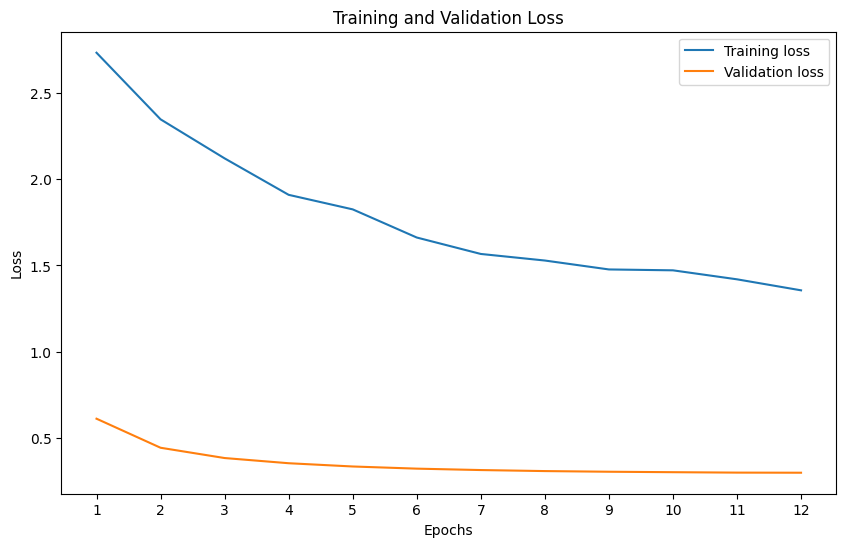

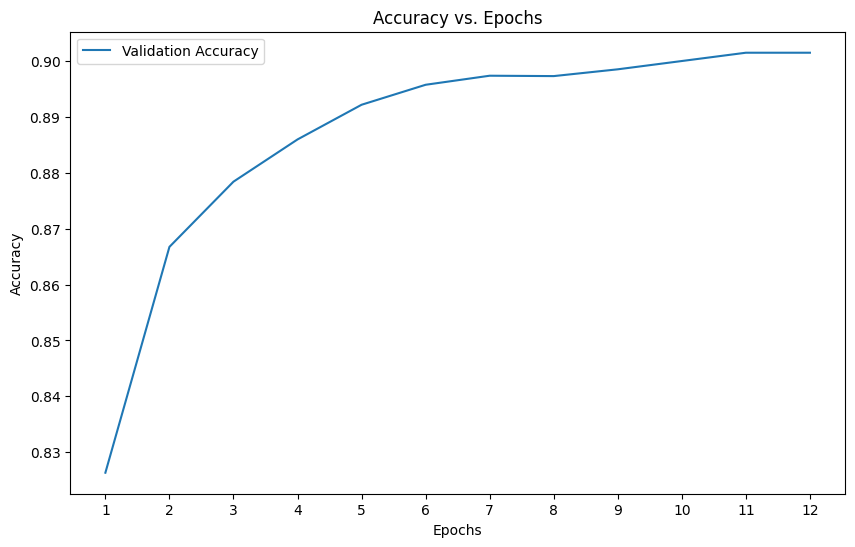

In [ ]:
model = XLMRobertaForTokenClassification.from_pretrained(model_name, num_labels=len(unique_labels))

# Freeze all layers except the classifier
for param in model.roberta.parameters():
    param.requires_grad = False

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters())


def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=2).flatten()
    true_labels = labels.flatten()
    valid_indices = true_labels != -100
    true_labels = true_labels[valid_indices]
    pred_labels = predictions[valid_indices]
    accuracy = np.sum(true_labels == pred_labels) / len(true_labels)
    return {'accuracy': accuracy}


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=12,
    per_device_train_batch_size=8, #16
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    logging_steps=10,
    learning_rate=1e-3, #2e-5, 1e-4
)

# Initialize wandb
wandb.init(project='Chinese POS tagging with RoBERTa', entity='hohsuann')
wandb.config = {
  "learning_rate": 0.001,
  "epochs": training_args.num_train_epochs,
  "batch_size": 32
}

print("Starting training...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

print("Training completed.")

wandb.finish()

# Visualize Training and Validation Loss
log_history = trainer.state.log_history

# Calculate average losses per epoch
epoch_training_loss = defaultdict(list)
epoch_validation_loss = defaultdict(list)

for log in log_history:
    if 'loss' in log and 'eval_loss' not in log:
        epoch_training_loss[log['epoch']].append(log['loss'])
    if 'eval_loss' in log:
        epoch_validation_loss[log['epoch']].append(log['eval_loss'])

# Calculate the mean of the losses per epoch
avg_training_loss = [sum(losses) / len(losses) for epoch, losses in sorted(epoch_training_loss.items())]
avg_validation_loss = [sum(losses) / len(losses) for epoch, losses in sorted(epoch_validation_loss.items())]

num_epochs = training_args.num_train_epochs

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), avg_training_loss[:num_epochs], label='Training loss')
plt.plot(range(1, num_epochs + 1), avg_validation_loss[:num_epochs], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xticks(range(1, num_epochs + 1))
plt.show()

# Plotting Accuracy vs Epochs
accuracy_scores = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), accuracy_scores, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xticks(range(1, num_epochs + 1))
plt.show()


In [1]:
!nvidia-smi

Wed Mar 13 12:25:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--